# Experimental Holography
In this notebook, we:
- Connect to an SLM and a camera.
- Produce and view a simple hologram.
- Calibrate the relationship between the coordinate spaces of the camera and the SLM using a Fourier calibration.
- TODO: finish list

TODO: Add an image about how the components are placed physically.

In [10]:
# Reload source code automatically.
%load_ext autoreload
%autoreload 2 
# Plot inline.
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Configure how images are displayed.
mpl.rc('image', cmap='Blues')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Connect to Hardware

First, we would like to connect to our SLM. We interface with an SLM through an SLM object, which allows us to manipulate and view the state of a single SLM. Each SLM object is an instance of the `SLM` class. The two primary subclasses of the `SLM` superclass that you will use are `ScreenMirrored` and `Santec` [0]. `ScreenMirrored` is designed for SLMs that act like another display for your computer, e.g. ThorLabs SLMs. The `Santec` class interfaces with Santec's proprietary programming library, providing more functionality, e.g. changing the voltage table for a supplied wavelength via USB communication, than can be communicated with the display alone.

When we originally ran this notebook we used a Santec SLM, so we used the `Santec` class. If you have a different type of SLM, replace `Santec` with the corresponding class, e.g. `ScreenMirrored`. If you believe your SLM is not supported by the currently available classes, please open a GitHub issue [1].

[0] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.html

[1] https://github.com/QPG-MIT/slmsuite/issues

In [2]:
from slmsuite.hardware.slms import Santec

Each SLM class has a `.info()` method which will show you the available SLMs to connect to.

In [3]:
Santec.info();

display_number, display_name:
#,  Name
1,  SB220Q,ACR,06AB,50341080
2,  LCOS-SLM,SOC,8001,2018021001
3,  LCOS-SLM,SOC,8001,2018021001
4,  
5,  
6,  
7,  
8,  


Display number 1 is our monitor, and display 2 and 3 are the two SLMs that were connected to this computer. We want to use the first SLM, which is connected to display 2. The syntax for constructing an instance of the class can be found in the documentation [2]. Additionally, we are using an 835nm laser.

[2] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.santec.Santec.html#slmsuite.hardware.slms.santec.Santec.__init__

In [7]:
slm = Santec(slm_number=1, display_number=2, wav_um=0.835)

Santec initializing... success
Current wavelength table: wav = 780 nm, maxphase = 2.00pi
Desired wavelength table: wav = 835 nm, maxphase = 2.00pi
     ...Updating wavelength table (this may take 30 seconds)...
Updated wavelength table: wav = 835 nm, maxphase = 2.03pi
Looking for display... success
Opening LCOS-SLM,SOC,8001,2018021001... success


Next, we would like to connect to our Camera. We interface with a camera using a `Camera` object, which is an instance of the `Camera` class. Each camera vendor has a different protocol for communicating with their cameras and supports different capabilities, so there are many more `Camera` subclasses than `SLM` subclasses.

When we originally ran this notebook we used a Thorlabs camera, so we used the `ThorCam` class. If you believe your camera is not currently supported by the available classes [3], please file a GitHub issue [1].

[3] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.html#

In [8]:
from slmsuite.hardware.cameras import ThorCam
ThorCam.info();

vimba not installed. Install to use AlliedVision cameras.
PySpin not installed. Install to use FLIR cameras.
pymmcore not installed. Install to use Micro-Manager cameras.
ThorCam serials:
"09717"
"13316"
"17042"


In [9]:
cam = ThorCam(serial="09717")

TLCameraSDK initializing... success
Looking for cameras... success
ThorCam sn "09717" initializing... success


## Display a Simple Hologram

First we would like to confirm that we can see the laser on the camera. We display a phase pattern on the slm via the `.write()` method [4]. To write zero phase to the SLM, we pass `None` to this method in place of a phase pattern. To take an image on the camera, we call the `.get_image()` method [5].

[4] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.slm.SLM.html#slmsuite.hardware.slms.slm.SLM.write
[5] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.camera.Camera.html#slmsuite.hardware.cameras.camera.Camera.get_image

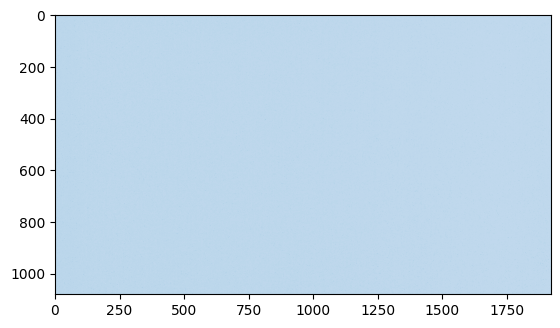

In [11]:
slm.write(None)
img = cam.get_image()
plt.imshow(img)

Next, we'll try to move the laser spot by applying a blaze (a phase pattern where the phase at a point is proportional to that point's distance from the origin) to the SLM [6].

Many common phases to create desired amplitude distributions, including the blaze that we will apply, are available in the `slmsuite.holography.toolbox` module [7]. On instantiation, each SLM creates arrays containing the x and y coordinates of its pixels, accessible through the `.x_grid` and `.y_grid` attributes. For convenience, we can pass our SLM object to the phase pattern generation functions in `toolbox` in place of the grids themselves, and the coordinates to evaluate the phase pattern on, as well as the shape of the phase pattern, will be handeled appropriately.

By default, the units that `toolbox.blaze` interprets the `vector` argument in is k_x/k of the SLM, which are equivalent to radians in the small angle approximation,
so we will steer the beam 0.1 radians in x and y. Other units can be chosen with the `toolbox.convert_blaze_vector` method [8].

[6] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.blaze.html#slmsuite.holography.toolbox.blaze

[7] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.html

[8] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.convert_blaze_vector.html#slmsuite.holography.toolbox.convert_blaze_vector

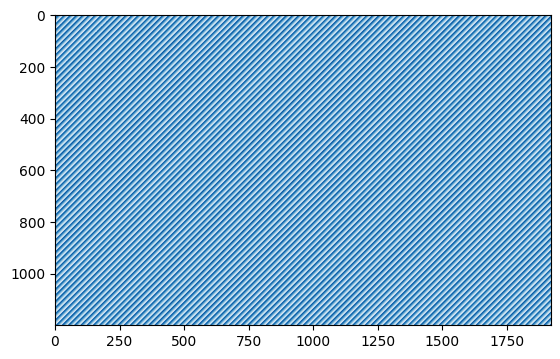

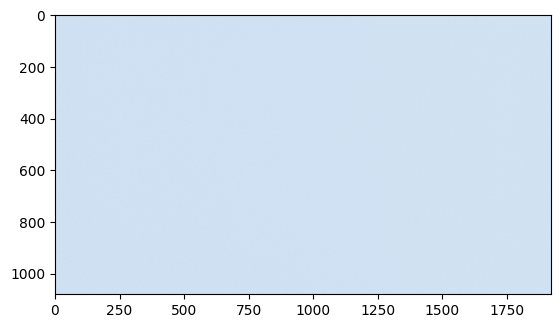

In [16]:
from slmsuite.holography import toolbox
phase = toolbox.blaze(slm, vector=(0.1, 0.1))
slm.write(phase)
plt.imshow(np.mod(phase, 2 * np.pi))
plt.show()
plt.imshow(cam.get_image())
plt.show()

## Fourier Calibration

Typically, we would like to steer the beam to a particular camera coordinate. However, it is not obvious at which angle the beam should be deflected from the SLM to arrive at a given camera coordinate. For a camera which is in the Fourier plane of the SLM, we know that the Fourier coordinate space of the SLM (kx, ky) will be related linearly to the image coordinate space of the camera (x, y). We find this linear transformation by means of an experimental calibration routine. In particular, we design a hologram to display on the SLM that diffracts the incident beam into spots at known (kx, ky) points in the SLM's Fourier space. We fit the spots that appear on the camera to points  (x, y), and determine how the kxy_slm points are related to the xy_cam points.

To expose the type of relationship between our camera and SLM, and to store information about their relationship, e.g. the relationship between their coordinate spaces, we create a `FourierSLM` object [8].

[8] https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM

In [17]:
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)

We can control the number of spots in the array, as well as the distance between spots (pitch, measured in SLM kx coordinates) using the `.fourier_calibrate()` method's arguments. Using more spots, and using a smaller pitch, will make the Fourier calibration, and therefore holography, more accurate.

Currently, the `fourier_calibrate` routine uses WGS to find a hologram to create the specified spot array. Then, it fits the discrete Fourier transform (DFT) of the image on the camera to a blob array using opencv-python's blob array detection method. It then computes the lattice vectors for this array to define the linear transformation between the coordinate systems. Then, an image of the detected array is convolved with the original image to find the center, and the autocorrelation function is used to determine the center of the array, which defines the offset between the coordinate spaces. TODO: I might not have explained the last part correctly.

The array detection is sensitive to the exposure of the image, and an error will be thrown if not enough array spots are found given how many were supposed to be created.

In [ ]:
fs.fourier_calibrate(array_shape=(60, 40), array_pitch=(15, 20))